### Shift Analysis

In this notebook we will make an analysis about the shift behavior, comparing with theoretical predictions, to do so, we will:

* Define methods to convert the raw data to refined information;
* Fit the datasets;
* Comparision between theory and experimental results.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Useful methods](#2)

- [3 - Loading data and applying LinearRegression fit](#3)

- [4 - Simulation for comparison](#4)

- [5 - Plots and comparison with theoretical predictions](#5)

<a name='1'></a> 
### 1. Packages and imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn


In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='1'></a> 
### 2. Useful methods

Here we will define methods to convert the digital gain from the red pitaya to an analog value, method to create the parameters used in the plot and a function to include information from the first and third quartil.

In [3]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    return -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution


def get_plot_params(df):
    '''
    Extract median and std from shifts to create plot with shifts and 
    the respectives error bars
    '''
    filt_grouped = df.groupby('final_gain', as_index=False).agg(np.median)
    gains = filt_grouped['final_gain'].values
    median_shifts = filt_grouped['shift'].values
    std = df.groupby('final_gain').agg(np.std)['shift'].values
    return gains, median_shifts, std



def include_quartis(df):
    '''
    Include Q1 and Q3 values for each gain to remove outliers and 
    execute data cleaning
    '''
    q1 = df.groupby('gain', as_index=False).quantile(0.25)
    q1['shift_q1'] = q1['shift']
    q1 = q1.drop('shift', axis=1)
    df = pd.merge(df, q1[['gain', 'shift_q1']], on='gain')
    q3 = df.groupby('gain', as_index=False).quantile(0.75)
    q3['shift_q3'] = q3['shift']
    q3 = q3.drop('shift', axis=1)
    df = pd.merge(df, q3[['gain', 'shift_q3']], on='gain')
    df['diq'] = df['shift_q3'] - df['shift_q1']
    df['upper'] = df['shift_q3'] + 1.5*df['diq']
    df['bottom'] = df['shift_q1'] - 1.5*df['diq']
    return df

<a name='3'></a> 
### 3. Loading data and applying LinearRegression fit

With the auxiliary methods defined, we will load the data from the `data.csv` dataframe, which contain columns specifying the `gain` in digital units, `batch` and angular frequencies (with and without perturbation). For comparison we will use two fit function, one defining a linear function a using `curve_fit` from `scipy.optimization` and other with `LinearRegression()` model from `scikit-learning`.

In [4]:
df = pd.read_csv('../data/shift/data.csv', index_col=False)
df.head()

,gain,batch,omega,omega_ref
0,10394,0,80519.193286,80058.792346
1,10601,0,79652.248500,81345.428762
2,10824,0,80586.942211,81274.120058
3,11065,0,80608.286129,80792.427812
4,11332,0,80649.449494,80750.302388


In [5]:
df = df[~df['gain'].isin([7388, 8000, 8384, 9000])]
df['shift'] = df['omega'] - df['omega_ref']
df = include_quartis(df)
df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
df['gain'] = df['gain'].apply(convert_gains)
df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['gain'].values,3)
df = df.sort_values(by=['final_gain'])

filt_df = df[(df['final_gain']>-4e6)&(df['final_gain']<4e6)]
out_of_perturbation = df[(df['final_gain']<-4e6)|(df['final_gain']>4e6)] 
filt_df = df.copy()
gains, median_shifts, std = get_plot_params(filt_df)
gains_pert, median_shifts_pert, std_pert = get_plot_params(out_of_perturbation)

X = filt_df['final_gain'].values.reshape((-1,1))
y = filt_df['shift'].values

In [6]:
def line(x, a):
    return a*x

In [7]:
ans, cov = curve_fit(line, gains, -median_shifts)
ans, np.sqrt(cov[0,0])

(array([0.00054106]), 8.555400510194927e-06)

In [8]:
model = LinearRegression().fit(gains.reshape((gains.shape[0], 1)), -median_shifts)
r_sq = model.score(gains.reshape((gains.shape[0], 1)), -median_shifts)
model.coef_, r_sq

(array([0.00054107]), 0.9925606003643307)

<a name='4'></a> 
### 4. Simulation for comparison


In [9]:
freq = 79e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = 13578.7501
env = Particle(omega, gamma, radius=73e-9)

In [10]:
def extract_central_freq(freq, psds):
    indexes = np.argwhere((freq>65000) & (freq <95000))
    freq_cropped, power_cropped = freq[indexes], psds[indexes]
    p0 =  [39103.417023, 2*np.pi*80000.0, 13000.2758744481, 0]
    ans, cov = curve_fit(lorentzian, 2*np.pi*freq_cropped[:, 0], power_cropped[:,0], p0=p0, maxfev=1000)
    return ans[1], cov[1,1]


def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base


def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, delta_t, N_time,  M, gain_range):
    cubic_variables = {i:{'gain': gain, 
                          'freq':[],  'centra_freq': None, 'central_freq_std': None}
                          for i, gain in enumerate(gain_range)}
    print("-- Creating traces --")
    for key in tqdm(cubic_variables.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, 
                              env.thermal_force_std, delta_t, 
                              N_time, cubic_variables[key]['gain']*(env.zp_x**3/env.zp_p), 0)
            data = np.array(data)
            cubic[i, :] = data
        freq, pxx = psd(cubic, delta_t)
        central_freq, cov = extract_central_freq(freq, (env.zp_x**2)*pxx.mean(axis=0))
        cubic_variables[key]['central_freq'] = central_freq/(2*np.pi)
        cubic_variables[key]['central_freq_std'] = np.sqrt(cov)/(2*np.pi)
    return cubic_variables

In [11]:
sim_gains = np.linspace(-6e6, 6e6, 200)
cubic_variables = generate_traces(env, delta_t, N_time, M, sim_gains)
sim_gains = sim_gains/1e6


-- Creating traces --


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [09:59<00:00,  3.00s/it]


In [15]:
shifts = np.array([-(cubic_variables[key]['central_freq']-freq) for key in cubic_variables.keys()])
delta_sim, _ = curve_fit(line, 1e6*sim_gains, shifts)

In [16]:
delta_sim, np.sqrt(_)

(array([0.00054954]), array([[2.04957805e-06]]))

<a name='5'></a> 
### 5. Plots and comparison with theoretical predictions

With the plot points extracted and the linear regression model fitted we will

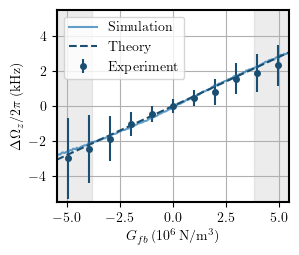

In [17]:
gain_linspace = np.linspace(1.4*df['final_gain'].values.min(), 
                    1.4*df['final_gain'].values.max(), 100)   
y = model.coef_*gain_linspace + model.intercept_
delta_f = -0.000558736548199816 
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4, 4.2))
fig.set_size_inches(3, 2.5, forward=True)
plt.ylim([-5.5, 5.5])
plt.xlim([-5.5, 5.5])
plt.plot(sim_gains, shifts/1e3, alpha=0.7)
plt.plot(gain_linspace/1e6, -gain_linspace*delta_f/1e3, linestyle='--', color=colors[2])

plt.errorbar(gains[::5]/1e6, -median_shifts[::5]/1e3, yerr=std[::5]/1e3, 
                fmt='o', color=colors[2], markersize=4)   
plt.grid()
plt.xlabel(r'$G_{fb} \,(10^6\, \textrm{N/m}{}^3)$')
plt.ylabel(r'$\Delta \Omega_z/2\pi$ (kHz)')
plt.legend(['Simulation', 'Theory', 'Experiment'], fontsize=10)
plt.fill_between([-5.5, -3.83], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
plt.fill_between([3.83, 5.5], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
#plt.savefig('../plots/test_shift.pdf', bbox_inches='tight', dpi=300)
plt.show()